# 2. `tf.data` input pipelines for PyTorch: GPU disabled for TensorFlow

In this case the only visible device is set to be the cpu.
When this is done, what changes is that during the definition of the `tf.data` dataset, tensorflow doesn't preallocate the memory for the batches on the GPU (that would be \~1101MB for the data used in this notebook).

Like this, the data is allocated on the GPU only when doing `.to(device)` to a torch tensor. The time measured for 800 batches is around 2.9 seconds. Similar to what pytorch takes. The same thing with `tf.data` without the GPU unset, takes \~400 miliseconds and uses the same memory (\~1101MB).

The idea used in this notebook comes from the Kaggle notebook [TF-DS for PyTorch](https://www.kaggle.com/hirotaka0122/tf-ds-for-pytorch).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tf.config.set_visible_devices(
    tf.config.list_physical_devices('CPU')[0]
)

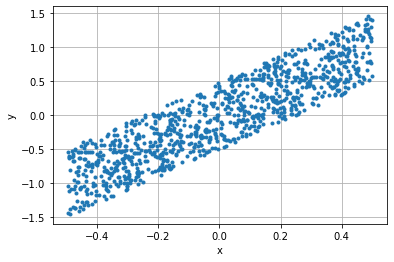

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.shuffle(1000)  # shuffle by chunks of 1000 samples. In this case, that's the how dataset.
dataset = dataset.batch(128)     # set the batch size
# dataset = dataset.prefetch(100)
dataset = dataset.repeat(100)    # set the number of epocs

2021-11-25 18:40:34.126511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dataset_np = tfds.as_numpy(dataset)

In [6]:
%%time

device = 0
for x, y in dataset_np:
    x_dev = torch.tensor(x).to(device)
    y_dev = torch.tensor(y).to(device)

CPU times: user 2.34 s, sys: 644 ms, total: 2.98 s
Wall time: 2.99 s
